In [1]:
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import tqdm
import sys
import numpy as np
import sklearn
import scipy
import warnings
warnings.filterwarnings(action='once')
from scib_metrics.benchmark import Benchmarker


sc.settings.figdir=os.path.expanduser('~/WbFigures/JorstadIntegrations')
sc._settings.settings._vector_friendly=True
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.family': 'DejaVu Sans',
    'font.sans-serif': 'DejaVuSansMono',
    'pdf.fonttype': 42
})

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
if device.type == 'cuda':
    print("GPU count:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


not all packages available
Running on cpu


In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
seaborn.set_theme(style="ticks", rc=custom_params)

In [ ]:
model_tag='1.9.1.8.5_JorstadAll_final_noQ_INP'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
model_path='/home/matthew.schmitz/Matthew/models/'+model_tag

adata = sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.5_JorstadAll_final_noQ_INP/p3_adata.h5ad'))
# np.savetxt(os.path.join(out_reductions,"X_antipode.csv"), adata.obsm["X_antipode"], delimiter=",")
adata.uns['organism_colors']=['blue','red','green','yellow','orange','cyan','magenta','teal','goldenrod','purple','maroon','pink','violet','black','grey','beige']
batch_key='batch'
discov_key='organism'
layer_key='UMIs'

In [ ]:
for k in adata.obsm.keys():
    adata.obsm[k] = np.array(adata.obsm[k])

In [ ]:
import h5py
import anndata
with h5py.File('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/cortex_data/jorstad_merge_xa.h5ad', "r") as f:
    xa_obs=anndata.experimental.read_elem(f["obs"])
xa_obs = xa_obs.loc[xa_obs.index[xa_obs.index.isin(adata.obs.index)],:]
xa_obs = xa_obs.loc[~xa_obs.index.duplicated(),:]

In [ ]:
import h5py
import anndata
with h5py.File('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/cortex_data/jorstad_cross_species/Combined_genenames.h5ad', "r") as f:
    xs_obs=anndata.experimental.read_elem(f["obs"])
xs_obs = xs_obs.loc[xs_obs.index[xs_obs.index.isin(adata.obs.index)],:]
xs_obs = xs_obs.loc[~xs_obs.index.duplicated(),:]

In [ ]:
# adata.obs['CrossArea_cluster'] = adata.obs['CrossArea_cluster'].astype(str)
adata.obs.loc[xa_obs.index,'CrossArea_cluster'] = xa_obs['CrossArea_cluster']
adata.obs['tissue'] = 'middle temporal gyrus'
adata.obs.loc[xa_obs.index,'tissue'] = xa_obs['tissue']

# adata.obs['CrossArea_cluster'] = adata.obs['CrossArea_cluster'].astype(str)
adata.obs.loc[xs_obs.index,'XS_cluster'] = xs_obs['Cluster']

In [ ]:
study = []
for xa,xs in zip(~adata.obs['CrossArea_cluster'].isna(),~adata.obs['XS_cluster'].isna()):
    if xa:
        study.append('cross-area')
    elif xs:
        study.append('cross-species')
    else:
        study.append('nan')
adata.obs['study'] = study

In [ ]:
out_reductions='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/JorstadIntegrations'

In [ ]:
batch_key='batch'
discov_key='organism'
layer_key='UMIs'
MDE_KEY = "X_antipode_UMAP"

In [10]:
# import scanorama
# import pyliger
from harmony import harmonize

In [11]:
%%time
# import scvi
# #adata=sc.read_h5ad('/home/matthew.schmitz/Matthew/models/1.9.1.8.1_RunRetinaAllNoPsi/p4_adata.h5ad',backed='r')
# scvi_model=scvi.model.SCVI.load('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.1_RunRetinaAllNoPsiSCVIsupervise',adata=adata) 
# SCVI_LATENT_KEY = "X_SCVI"
# adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation(adata)

# np.savetxt(os.path.join(out_reductions,"X_SCVI.csv"), adata.obsm["X_SCVI"], delimiter=",")

CPU times: user 1e+03 ns, sys: 5 μs, total: 6 μs
Wall time: 14.5 μs


In [12]:
# sc.pp.scale(adata,zero_center=False)
# sc.pp.pca(adata)
# np.savetxt(os.path.join(out_reductions,"X_pca.csv"), adata.obsm["X_pca"], delimiter=",")

In [13]:
# %%time
# adata.obsm["X_harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key=discov_key)
# np.savetxt(os.path.join(out_reductions,"X_harmony.csv"), adata.obsm["X_harmony"], delimiter=",")

In [14]:
# %%time
#not enough memory
# # List of adata per batch
# batch_cats = adata.obs[discov_key].cat.categories
# adata_list = [adata[adata.obs[discov_key] == b].copy() for b in batch_cats]
# scanorama.integrate_scanpy(adata_list)

# adata.obsm["X_Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
# for i, b in enumerate(batch_cats):
#     adata.obsm["X_Scanorama"][adata.obs[discov_key] == b] = adata_list[i].obsm["X_scanorama"]


In [15]:
# %%time
#not enough memory
# bdata = adata.copy()
# # Pyliger normalizes by library size with a size factor of 1
# # So here we give it the count data
# bdata.X = bdata.layers["UMIs"]
# # List of adata per batch
# batch_cats = adata.obs[discov_key].cat.categories
# adata_list = [bdata[bdata.obs[discov_key] == b].copy() for b in batch_cats]
# for i, ad in enumerate(adata_list):
#     ad.uns["sample_name"] = batch_cats[i]
#     # Hack to make sure each method uses the same genes
#     ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


# liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# # Hack to make sure each method uses the same genes
# liger_data.var_genes = bdata.var_names
# pyliger.normalize(liger_data)
# pyliger.scale_not_center(liger_data)
# pyliger.optimize_ALS(liger_data, k=30)
# pyliger.quantile_norm(liger_data)


# adata.obsm["X_liger"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
# for i, b in enumerate(batch_cats):
#     adata.obsm["X_liger"][adata.obs[discov_key] == b] = liger_data.adata_list[i].obsm["H_norm"]


In [16]:
# obsm_keys=["X_pca", "X_Scanorama", "X_liger", "X_harmony", "X_scVI", "X_antipode"]
# obsm_keys=[x for x in obsm_keys if x in adata.obsm.keys()]

# for x in obsm_keys:
#     try:
#         np.savetxt(os.path.join(out_reductions,x+".csv"), adata.obsm[x], delimiter=",")
#     except:
#         print(x,'FAILED')


# Downstream Analysis

In [ ]:
obsm_keys=["X_pca", "X_Scanorama", "X_liger", "X_harmony", "X_scVI",'X_antipode']
for x in obsm_keys:
    print(x)
    try:
        adata.obsm[x]=np.loadtxt(os.path.join(out_reductions,x+".csv"), delimiter=",")
        MDE_KEY = x+"_UMAP"
        adata.obsm[MDE_KEY]=np.loadtxt(os.path.join(out_reductions,MDE_KEY+".csv"), delimiter=",")
    except:
        print(x,'FAILED')

obsm_keys = [x for x in obsm_keys if x in adata.obsm.keys()]

In [ ]:
def clip_latent_dimensions(matrix, x):
    """
    Clips each latent dimension of the matrix at the 0+x and 100-x percentile.

    Parameters:
    - matrix: A 2D NumPy array of shape [number of observations, latent dimensions].
    - x: The percentage for the lower and upper bounds (0 < x < 50).

    Returns:
    - A 2D NumPy array with the same shape as the input matrix, with values clipped.
    """
    # Ensure x is within the valid range
    if x < 0 or x > 50:
        raise ValueError("x must be between 0 and 50")

    # Initialize a clipped matrix with the same shape as the input matrix
    clipped_matrix = np.zeros_like(matrix)

    # Iterate over each column (latent dimension) to apply clipping
    for col_idx in range(matrix.shape[1]):
        # Calculate the percentiles for the current column
        lower_percentile = np.percentile(matrix[:, col_idx], x)
        upper_percentile = np.percentile(matrix[:, col_idx], 100-x)
        
        # Clip the values in the current column based on the calculated percentiles
        clipped_matrix[:, col_idx] = np.clip(matrix[:, col_idx], lower_percentile, upper_percentile)

    return clipped_matrix


In [ ]:
import cuml
plot_obsm_keys=["X_pca", "X_Scanorama", "X_liger", "X_harmony", "X_scVI","X_antipode"]
plot_obsm_keys = [x for x in plot_obsm_keys if x in adata.obsm.keys()]

for x in plot_obsm_keys:
    print(x)
    # try:
    MDE_KEY = x+"_UMAP"
    if not MDE_KEY in adata.obsm.keys():
        
        umap = cuml.UMAP(n_neighbors = 60)
        adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm[x]),0.1)
        torch.cuda.empty_cache()
        np.savetxt(os.path.join(out_reductions,MDE_KEY+".csv"), adata.obsm[MDE_KEY], delimiter=",")
        
    sc.pl.embedding(
        adata,
        basis=MDE_KEY,
        color=["CrossArea_cluster","XS_cluster",'level_2'],legend_fontsize=6,legend_fontweight='normal',
        legend_loc='on data',save=f'_{"CrossArea_cluster"}.pdf',palette=sc.pl.palettes.godsnot_102
    )
    
    sc.pl.embedding(
        adata,
        basis=MDE_KEY,
        color=[discov_key,'study','tissue'],legend_fontsize=6,palette=sc.pl.palettes.godsnot_102,
        legend_fontweight='normal',save=f'_{discov_key}.pdf'
    )
    # except:
    #     print(x,'FAILED')

Length of palette colors is smaller than the number of categories (palette length: 102, categories length: 169. Some categories will have the same color.
saving figure to file /home/matthew.schmitz/WbFigures/JorstadIntegrations/X_antipode_UMAP_level_2.pdf


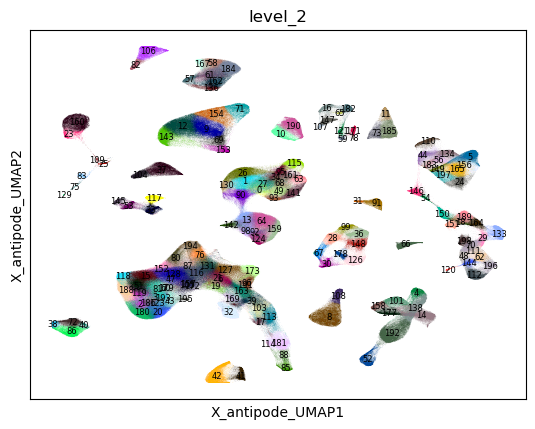

In [20]:
sc.pl.embedding(
    adata,
    basis='X_antipode_UMAP',
    color=["level_2"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',save=f'_{"level_2"}.pdf',palette=sc.pl.palettes.godsnot_102
)


In [21]:
# obsm_keys=["X_pca", "X_Scanorama", "X_liger", "X_harmony", "X_scVI", "X_antipode"]
# for x in obsm_keys:
#     print(x)
#     try:
#         adata.obsm[x]=np.loadtxt(os.path.join(out_reductions,x+".csv"), delimiter=",")
#     except:
#         print(x,'FAILED')

# obsm_keys = [x for x in obsm_keys if x in adata.obsm.keys()]

In [22]:
adata.obs_names_make_unique()

Metrics:  20%|██        | 2/10 [10:50<41:36, 312.01s/it, Bio conservation: clisi_knn]       /home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/chex/_src/dataclass.py:302: DeprecationWarning: unzip2 was deprecated in JAX v0.6.0 and will be removed in JAX v0.7.0.
  flatten = lambda d: jax.util.unzip2(sorted(d.__dict__.items()))[::-1]

Metrics:  50%|█████     | 5/10 [13:16<08:31, 102.21s/it, Batch correction: kbet_per_label]

INFO     147 clusters consist of a single batch or are too small. Skip.                                            


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))

Metrics:  60%|██████    | 6/10 [13:20<04:35, 68.90s/it, Batch correction: graph_connectivity]/home/matthew.schmitz/Matthew/utils/minifo

INFO     147 clusters consist of a single batch or are too small. Skip.                                            


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))

Metrics:  60%|██████    | 6/10 [08:30<02:24, 36.07s/it, Batch correction: graph_connectivity]/home/matthew.schmitz/Matthew/utils/minifo

INFO     147 clusters consist of a single batch or are too small. Skip.                                            


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: Deprecation

INFO     147 clusters consist of a single batch or are too small. Skip.                                            


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))

Metrics:  60%|██████    | 6/10 [29:41<08:32, 128.21s/it, Batch correction: graph_connectivity]/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:  70%|███████   | 7/10 [29:42<04:19, 86.56s/it, Batch correction: pcr_comparison]    /home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance co

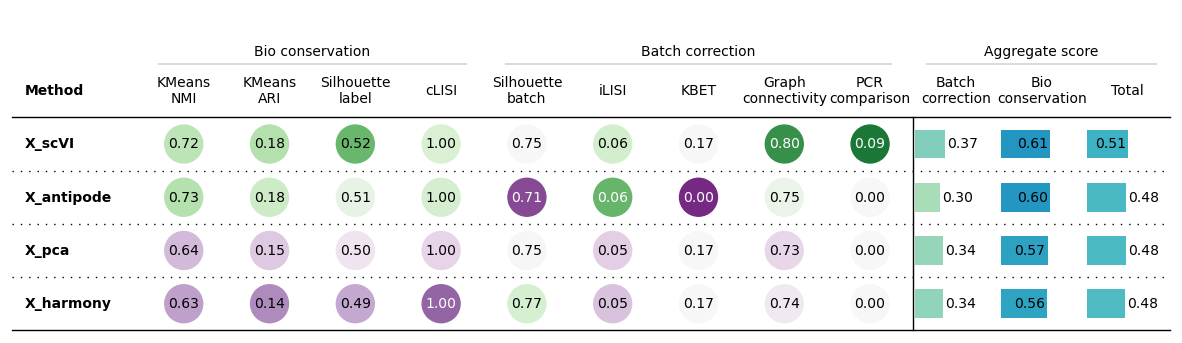

Time: 67 min 39 sec


In [23]:
# conda create -n rapids-25.06 -c integrations_gpu -c conda-forge -c nvidia  \
#     rapids=25.06 python=3.13 'cuda-version>=12.0,<=12.8'
# pip install scanpy scib scib-metrics harmony-pytorch
from scib_metrics.nearest_neighbors import NeighborsResults
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
xdata=sc_analysis.select_k_cells(adata[~adata.obs['CrossArea_cluster'].isna(),:],'level_2',50_000)

output_dir=os.path.join(sc.settings.figdir,'CrossArea_cluster')
try:
    os.mkdir(output_dir)
except:
    pass


from cuml.neighbors import NearestNeighbors
import numpy as np

def cuml_brute_force_nn(X: np.ndarray, k: int):
    """
    GPU brute‐force kNN using RAPIDS cuML.
    Returns exactly the k nearest neighbors for each row of X.
    """
    # cuML wants float32
    X32 = np.asarray(X, dtype=np.float32, order='C')
    # force a NumPy return so scIB can read it directly
    nn = NearestNeighbors(
        n_neighbors=k,
        algorithm='brute',
        metric='euclidean',
        output_type='numpy'
    )
    nn.fit(X32)
    distances, indices = nn.kneighbors(X32)
    return NeighborsResults(indices=indices.astype(np.int64),
                            distances=distances)


def cuml_ivfflat_nn(X: np.ndarray, k: int, nlist: int = 100, nprobe: int = 10):
    """
    GPU approximate kNN via IVF‐flat.
      • nlist  = # of Voronoi cells in the index
      • nprobe = # of cells to search at query time
    """
    X32 = np.asarray(X, dtype=np.float32, order='C')
    algo_params = {'nlist': nlist, 'nprobe': nprobe}
    nn = NearestNeighbors(
        n_neighbors=k,
        algorithm='ivfflat',
        metric='euclidean',
        algo_params=algo_params,
        output_type='numpy'
    )
    nn.fit(X32)
    distances, indices = nn.kneighbors(X32)
    return NeighborsResults(indices=indices.astype(np.int64),
                            distances=distances)
    
import time


biocons = BioConservation(isolated_labels=False)

start = time.time()
bm = Benchmarker(
    xdata,
    batch_key="batch",
    label_key="CrossArea_cluster",
    embedding_obsm_keys=obsm_keys,
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=biocons,
    batch_correction_metrics=BatchCorrection(),
    n_jobs=-1,
)
bm.prepare()
bm.benchmark()
end = time.time()
# bm.plot_results_table(save_dir=output_dir)
bm.plot_results_table(save_dir=output_dir,min_max_scale=False)
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")


In [24]:
df = bm.get_results(min_max_scale=False)
df.to_csv(os.path.join(output_dir,'scib-metrics.csv'))

Metrics:  50%|█████     | 5/10 [11:52<08:04, 96.90s/it, Batch correction: kbet_per_label]

INFO     167 clusters consist of a single batch or are too small. Skip.                                            


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))

Metrics:  60%|██████    | 6/10 [11:54<04:18, 64.64s/it, Batch correction: graph_connectivity]/home/matthew.schmitz/Matthew/utils/minifo

INFO     167 clusters consist of a single batch or are too small. Skip.                                            


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))

Metrics:  60%|██████    | 6/10 [10:05<02:48, 42.09s/it, Batch correction: graph_connectivity]/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  50%|█████     | 2/4 [22:06<21:46, 653.25s/it]tch correction: pcr_comparison]
                                                                                         
Metrics:  50%|█████     | 5/10 [13:42<07:34, 90.98s/it, Batch correction: kbet_per_label]

INFO     167 clusters consist of a single batch or are too small. Skip.                                            


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))

Metrics:  60%|██████    | 6/10 [13:43<04:01, 60.41s/it, Batch correction: graph_connectivity]/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  75%|███████▌  | 3/4 [35:52<12:12, 732.27s/it]tch correction: pcr_comparison]
                                                                                         
Metrics:  50%|█████     | 5/10 [39:38<20:56, 251.35s/it, Batch correction: kbet_per_label]

INFO     167 clusters consist of a single batch or are too small. Skip.                                            


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_kbet.py:183: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  idx_nonan = np.flatnonzero(np.in1d(labs, comp_size[comp_size >= comp_size_thresh].index))

Metrics:  60%|██████    | 6/10 [39:39<11:05, 166.26s/it, Batch correction: graph_connectivity]/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|██████████| 4/4 [1:15:35<00:00, 1133.92s/it] correction: pcr_comparison] 

                                                                                         

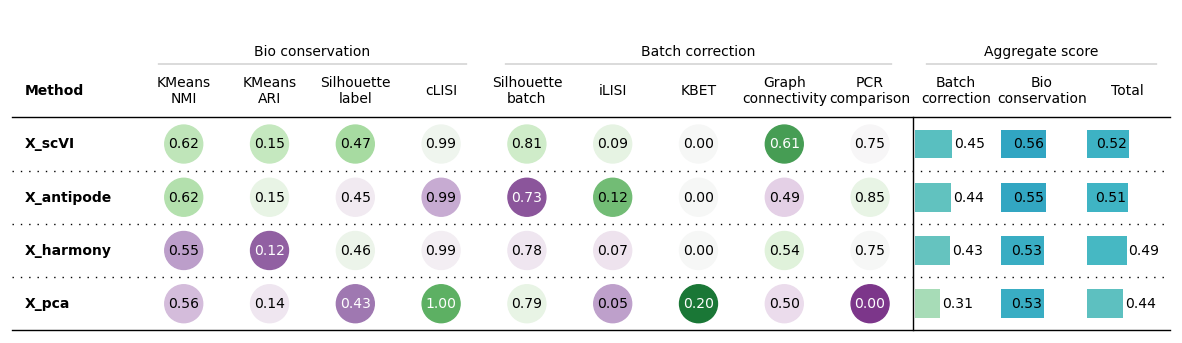

Time: 78 min 37 sec


In [25]:
# conda create -n rapids-25.06 -c integrations_gpu -c conda-forge -c nvidia  \
#     rapids=25.06 python=3.13 'cuda-version>=12.0,<=12.8'
# pip install scanpy scib scib-metrics harmony-pytorch
from scib_metrics.nearest_neighbors import NeighborsResults
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
xdata=sc_analysis.select_k_cells(adata[~adata.obs['XS_cluster'].isna(),:],'level_2',50_000)

output_dir=os.path.join(sc.settings.figdir,'XS_cluster')
try:
    os.mkdir(output_dir)
except:
    pass

biocons = BioConservation(isolated_labels=False)

start = time.time()
bm = Benchmarker(
    xdata,
    batch_key="batch",
    label_key="XS_cluster",
    embedding_obsm_keys=obsm_keys,
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=biocons,
    batch_correction_metrics=BatchCorrection(),
    n_jobs=-1,
)
bm.prepare()
bm.benchmark()
end = time.time()
# bm.plot_results_table(save_dir=output_dir)
bm.plot_results_table(save_dir=output_dir,min_max_scale=False)
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")


In [26]:
df = bm.get_results(min_max_scale=False)
df.to_csv(os.path.join(output_dir,'scib-metrics.csv'))

In [30]:
# import numpy as np
# import scipy.stats
# from cuml.neighbors import NearestNeighbors
# import tqdm

# def taxonomy_entropy(
#     adata,
#     annotations,
#     nearest_neighbors: int = 15,
#     dim: str = "X_scVI",
#     algorithm: str = "brute",
#     algo_params: dict = None,
# ):
#     """
#     Compute entropy (mixing) of annotations within each cell's local neighborhood,
#     using cuML NearestNeighbors on the GPU.

#     Args:
#         adata: AnnData with `annotations` in .obs and embeddings in .obsm[dim].
#         annotations: list of str, names of .obs columns to score.
#         nearest_neighbors: k for kNN.
#         dim: which embedding in adata.obsm to use.
#         algorithm: one of 'brute', 'ivfflat', 'auto', etc.
#         algo_params: dict of algorithm‐specific params (e.g. {'nlist':100,'nprobe':10}).
#     Returns:
#         The same AnnData, with new .obs columns named f"{dim}_{anno}_entropy".
#     """
#     # prepare data
#     X = np.asarray(adata.obsm[dim], dtype=np.float32, order='C')
#     algo_params = algo_params or {}

#     # build and query GPU kNN
#     nn = NearestNeighbors(
#         n_neighbors=nearest_neighbors,
#         algorithm=algorithm,
#         metric="euclidean",
#         algo_params=algo_params,
#         output_type="numpy",
#     )
#     nn.fit(X)
#     distances, indices = nn.kneighbors(X)
#     # indices: (n_cells, k) array of neighbor‐indices

#     # for each annotation, compute per‐cell entropy
#     for anno in annotations:
#         col = f"{dim}_{anno}_entropy"
#         entropy_vals = []
#         for nbrs in tqdm.tqdm(indices, desc=f"Entropy for {anno}"):
#             freqs = (
#                 adata.obs.iloc[nbrs][anno]
#                 .value_counts(normalize=True)
#                 .values
#             )
#             entropy_vals.append(scipy.stats.entropy(freqs))
#         adata.obs[col] = entropy_vals

#     return adata


import sklearn
def taxonomy_entropy(adata, annotations, nearest_neighbors = 15, dim = "X_scVI"):
    """Compute entropy (mixing) of annotations within a cells local neighborhood. 
    Author: Nelson Johansson
    Args:
        adata (.h5ad): adata object with annotations in adata.obs.
        annotations (list of str): Cell level annotations.
        nearest_neighbors (int): Number of nearest neighbors.
        dim (str): Dimensionality reduction within adata.obsm. Should be "X_scVI" but can be "X_umap".
    Example:
        adata = sc.read_h5ad("YOUR_ANNDATA.h5ad")
        adata = taxonomy_entropy(adata = adata, annotations=["Neighborhood", "Subclass"])
    Returns:
        adata
    """
    ## Build nearest neighbor tree for fast lookup
    print("Building nearest neighbor tree.")
    nnTree = sklearn.neighbors.KDTree(adata.obsm[dim])
    nearest_dist, nearest_ind = nnTree.query(adata.obsm[dim], k=nearest_neighbors)
    ##
    for anno in annotations:
        print("Computing entropy on: " + anno)
        adata.obs[dim+"_"+anno + "_entropy"] = -1 ## Initialize with a value outside range of entropy.
        for cell in tqdm.tqdm(range(0, adata.shape[0])):
            nearest_neighbors = nearest_ind[cell,:]
            adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
    return adata


In [31]:
# xdata = xdata.to_memory()

In [32]:
for x in obsm_keys:
    print(x)
    # try:
    xdata=taxonomy_entropy(xdata,['organism','study','batch'],nearest_neighbors = 30,dim=x)
    # except:
        # print(x,'FAILED')

X_pca
Building nearest neighbor tree.
Computing entropy on: organism


/scratch/fast/1595860/ipykernel_1392072/247869630.py:82: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[dim+"_"+anno + "_entropy"] = -1 ## Initialize with a value outside range of entropy.
  1%|          | 372/49967 [00:00<01:22, 600.57it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.39267446722755217' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 621.83it/s]


Computing entropy on: study


  1%|          | 254/49967 [00:00<01:19, 625.43it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1461447460085638' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 623.75it/s]


Computing entropy on: batch


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9131576096018579' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 617.28it/s]


X_harmony
Building nearest neighbor tree.
Computing entropy on: organism


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.194453006323357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 619.08it/s]


Computing entropy on: study


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5799151714181009' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 624.22it/s]


Computing entropy on: batch


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.748145010800415' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 621.37it/s]


X_scVI
Building nearest neighbor tree.
Computing entropy on: organism


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2984261026486807' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 619.59it/s]


Computing entropy on: study


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5432727813369008' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 622.11it/s]


Computing entropy on: batch


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.728396023706865' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 618.24it/s]


X_antipode
Building nearest neighbor tree.
Computing entropy on: organism


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2370186691212506' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 617.85it/s]


Computing entropy on: study


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6909233093138181' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 621.73it/s]


Computing entropy on: batch


  0%|          | 0/49967 [00:00<?, ?it/s]/scratch/fast/1595860/ipykernel_1392072/247869630.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.8580062396672252' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
100%|██████████| 49967/49967 [01:20<00:00, 616.94it/s]


In [33]:
df=xdata.obs.loc[:,[x for x in xdata.obs.columns if 'entropy' in x]].melt()
df.columns=['variable','entropy']
df['color'] = df['variable'].str.split('_').str[1]

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/integrations_gpu2/lib/python3.13/site-packages/seaborn/categorical.py:70

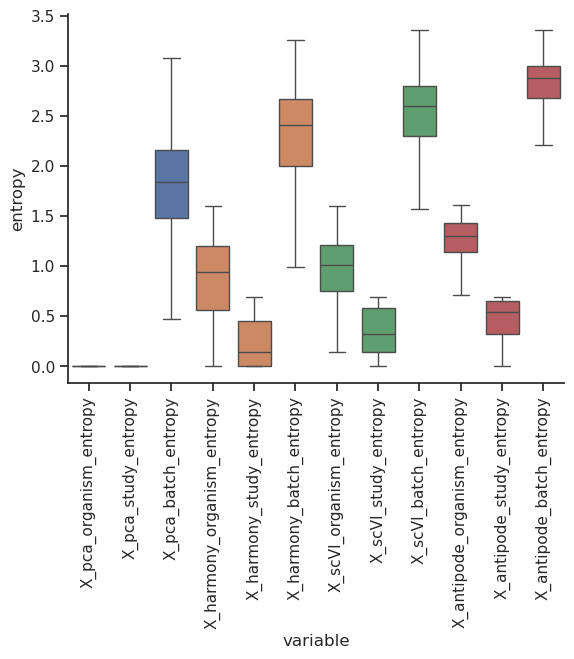

In [37]:
seaborn.boxplot(data=df,x='variable',y='entropy',hue='color',legend=None,showfliers=False)
plt.xticks(rotation=90)
plt.savefig(os.path.join(sc.settings.figdir,'entropy_violins.svg'))
plt.show()

In [35]:
xdata.obs.loc[:,[x for x in xdata.obs.columns if 'entropy' in x]].to_csv(os.path.join(sc.settings.figdir,'entropy_table.csv'))